In [1]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 4.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10

In [2]:
import os
import time
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from einops import rearrange, repeat
from einops.layers.torch import Rearrange, Reduce
import matplotlib.pyplot as plt
from datetime import datetime
from torch import Tensor
import time
import random
import shutil
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import accuracy_score, average_precision_score
from tqdm import tqdm
from torchvision.models.swin_transformer import swin_t, Swin_T_Weights
import torch.nn.functional as F
import json 
import timm
import torch.backends.cudnn as cudnn
import torch.distributed as dist

from timm.loss import LabelSmoothingCrossEntropy
from timm.utils import accuracy, AverageMeter

In [3]:
# Lớp AIDDataset tùy chỉnh
class AIDDataset(Dataset):
    def __init__(self, image_paths, labels, classes, class_to_idx, transform=None):
        """
        image_paths: Danh sách đường dẫn đến ảnh
        labels: Danh sách nhãn tương ứng
        classes: Danh sách tên các lớp
        class_to_idx: Ánh xạ từ tên lớp sang chỉ số
        transform: Các phép biến đổi (transforms) áp dụng lên ảnh
        """
        self.image_paths = image_paths
        self.labels = labels
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')  # Mở ảnh và chuyển sang RGB

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Hàm để tải toàn bộ dữ liệu từ thư mục
def load_aid_data(root_dir):
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"Directory {root_dir} does not exist")
    
    classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    if not classes:
        raise ValueError(f"No class directories found in {root_dir}")
    
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
    image_paths = []
    labels = []
    image_files = [[] for _ in range(len(classes))]

    for cls_idx, cls_name in enumerate(classes):
        cls_dir = os.path.join(root_dir, cls_name)
        cls_images = [os.path.join(cls_dir, img_name) for img_name in os.listdir(cls_dir) 
                     if img_name.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if not cls_images:
            print(f"Warning: No images found in {cls_dir}")
        image_files[cls_idx] = cls_images
        image_paths.extend(cls_images)
        labels.extend([class_to_idx[cls_name]] * len(cls_images))

    if not image_paths:
        raise ValueError("No images found in any class directories")
    
    return image_paths, labels, classes, class_to_idx, image_files

# Tải dữ liệu
data_dir = '/kaggle/input/aid-scene-classification-datasets/AID'
try:
    image_paths, labels, class_names, class_to_idx, image_files = load_aid_data(data_dir)
except Exception as e:
    print(f"Error loading data: {e}")
    exit(1)

# Lấy kích thước ảnh từ ảnh đầu tiên
image_width, image_height = None, None
try:
    image_width, image_height = Image.open(image_paths[0]).size
except IndexError:
    print("Error: No images found in the dataset")
    exit(1)
except Exception as e:
    print(f"Error opening first image: {e}")
    exit(1)

# In thông tin dataset
num_total = len(image_paths)
num_class = len(class_names)
print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])
 

Total image count: 10000
Image dimensions: 600 x 600
Label names: ['Airport', 'BareLand', 'BaseballField', 'Beach', 'Bridge', 'Center', 'Church', 'Commercial', 'DenseResidential', 'Desert', 'Farmland', 'Forest', 'Industrial', 'Meadow', 'MediumResidential', 'Mountain', 'Park', 'Parking', 'Playground', 'Pond', 'Port', 'RailwayStation', 'Resort', 'River', 'School', 'SparseResidential', 'Square', 'Stadium', 'StorageTanks', 'Viaduct']
Label counts: [360, 310, 220, 400, 360, 260, 240, 350, 410, 300, 370, 250, 390, 280, 290, 340, 350, 390, 370, 420, 380, 260, 290, 410, 300, 300, 330, 290, 360, 420]


In [5]:
import os
import shutil
from torchvision.datasets import ImageFolder
from collections import Counter

# Đường dẫn dataset gốc và thư mục lưu kết quả
source_dataset_path = '/kaggle/input/aid-scene-classification-datasets/AID'
output_base_path = '/kaggle/working/split_aid_dataset'

# Tạo các thư mục train, val, test nếu chưa có
train_dir = os.path.join(output_base_path, 'train')
val_dir = os.path.join(output_base_path, 'val')
test_dir = os.path.join(output_base_path, 'test')

for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)

# Tải dataset bằng ImageFolder
dataset = ImageFolder(source_dataset_path)
image_paths = [item[0] for item in dataset.samples]
labels = [item[1] for item in dataset.samples]
class_names = dataset.classes
class_to_idx = dataset.class_to_idx

# In thông tin dataset gốc
print(f"Total number of images: {len(dataset)}")
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")

# Phân loại ảnh theo từng lớp
class_images = {class_idx: [] for class_idx in range(len(class_names))}
for img_path, label in zip(image_paths, labels):
    class_images[label].append(img_path)

# In phân phối lớp gốc
print("\nPhân phối lớp trong dataset gốc:")
for class_idx, class_name in enumerate(class_names):
    count = len(class_images[class_idx])
    print(f"Lớp {class_idx} ({class_name}): {count} ảnh")

# Kiểm tra xem tất cả lớp có ảnh không
missing_classes = [class_name for class_idx, class_name in enumerate(class_names) if len(class_images[class_idx]) == 0]
if missing_classes:
    print(f"\nCảnh báo: Các lớp sau không có ảnh: {missing_classes}")
    raise ValueError("Một số lớp không có ảnh, không thể chia dữ liệu.")

# Chia đều từng lớp theo tỷ lệ 6:2:2
train_paths, val_paths, test_paths = [], [], []
train_labels, val_labels, test_labels = [], [], []

for class_idx, class_name in enumerate(class_names):
    # Danh sách ảnh của lớp hiện tại
    images = class_images[class_idx]
    total_images = len(images)
    
    # Tính số lượng ảnh cho train (60%), val (20%), test (20%)
    train_size = int(total_images * 0.6)  # 60%
    val_size = int(total_images * 0.2)    # 20%
    test_size = total_images - train_size - val_size  # Phần còn lại (đảm bảo tổng = 100%)

    # Điều chỉnh để tránh sai lệch do làm tròn
    if train_size + val_size + test_size > total_images:
        diff = train_size + val_size + test_size - total_images
        if val_size > diff:
            val_size -= diff
        else:
            test_size -= diff
    elif train_size + val_size + test_size < total_images:
        diff = total_images - (train_size + val_size + test_size)
        test_size += diff

    # Chia ảnh thành train, val, test (chia tuần tự, không ngẫu nhiên)
    train_split = images[:train_size]
    val_split = images[train_size:train_size + val_size]
    test_split = images[train_size + val_size:]

    # Thêm vào danh sách tổng
    train_paths.extend(train_split)
    val_paths.extend(val_split)
    test_paths.extend(test_split)
    train_labels.extend([class_idx] * len(train_split))
    val_labels.extend([class_idx] * len(val_split))
    test_labels.extend([class_idx] * len(test_split))

# Hàm để sao chép ảnh vào thư mục đích với cấu trúc thư mục con theo lớp
def copy_images(image_paths, labels, dest_dir, class_names):
    for class_name in class_names:
        class_dir = os.path.join(dest_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        print(f"Tạo thư mục: {class_dir}")
    
    for img_path, label in zip(image_paths, labels):
        class_name = class_names[label]
        dest_path = os.path.join(dest_dir, class_name, os.path.basename(img_path))
        try:
            shutil.copy(img_path, dest_path)
        except Exception as e:
            print(f"Lỗi khi sao chép ảnh {img_path} vào {dest_path}: {e}")

# Sao chép ảnh vào các thư mục train, val, test
copy_images(train_paths, train_labels, train_dir, class_names)
copy_images(val_paths, val_labels, val_dir, class_names)
copy_images(test_paths, test_labels, test_dir, class_names)

# Kiểm tra phân phối lớp trong các tập
def print_class_distribution(labels, class_names, dataset_name):
    class_counts = Counter(labels)
    print(f"\nPhân phối lớp trong tập {dataset_name}:")
    for class_idx in range(len(class_names)):
        count = class_counts.get(class_idx, 0)
        class_name = class_names[class_idx]
        print(f"Lớp {class_idx} ({class_name}): {count} ảnh")

# In phân phối lớp cho từng tập
print_class_distribution(train_labels, class_names, "Train")
print_class_distribution(val_labels, class_names, "Validation")
print_class_distribution(test_labels, class_names, "Test")

# In tổng số ảnh trong mỗi tập
print(f"\nTổng số ảnh trong tập Train: {len(train_paths)}")
print(f"Tổng số ảnh trong tập Validation: {len(val_paths)}")
print(f"Tổng số ảnh trong tập Test: {len(test_paths)}")

# Kiểm tra số lượng ảnh thực tế trong các thư mục
def verify_images_in_folders(dest_dir, class_names, dataset_name):
    print(f"\nKiểm tra số lượng ảnh thực tế trong thư mục {dataset_name}:")
    total_images = 0
    for class_name in class_names:
        class_dir = os.path.join(dest_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Lớp {class_name} không tồn tại trong {dataset_name}!")
            continue
        image_count = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"Lớp {class_name}: {image_count} ảnh")
        total_images += image_count
    print(f"Tổng số ảnh thực tế trong {dataset_name}: {total_images}")

verify_images_in_folders(train_dir, class_names, "Train")
verify_images_in_folders(val_dir, class_names, "Validation")
verify_images_in_folders(test_dir, class_names, "Test")

Total number of images: 10000
Number of classes: 30
Classes: ['Airport', 'BareLand', 'BaseballField', 'Beach', 'Bridge', 'Center', 'Church', 'Commercial', 'DenseResidential', 'Desert', 'Farmland', 'Forest', 'Industrial', 'Meadow', 'MediumResidential', 'Mountain', 'Park', 'Parking', 'Playground', 'Pond', 'Port', 'RailwayStation', 'Resort', 'River', 'School', 'SparseResidential', 'Square', 'Stadium', 'StorageTanks', 'Viaduct']

Phân phối lớp trong dataset gốc:
Lớp 0 (Airport): 360 ảnh
Lớp 1 (BareLand): 310 ảnh
Lớp 2 (BaseballField): 220 ảnh
Lớp 3 (Beach): 400 ảnh
Lớp 4 (Bridge): 360 ảnh
Lớp 5 (Center): 260 ảnh
Lớp 6 (Church): 240 ảnh
Lớp 7 (Commercial): 350 ảnh
Lớp 8 (DenseResidential): 410 ảnh
Lớp 9 (Desert): 300 ảnh
Lớp 10 (Farmland): 370 ảnh
Lớp 11 (Forest): 250 ảnh
Lớp 12 (Industrial): 390 ảnh
Lớp 13 (Meadow): 280 ảnh
Lớp 14 (MediumResidential): 290 ảnh
Lớp 15 (Mountain): 340 ảnh
Lớp 16 (Park): 350 ảnh
Lớp 17 (Parking): 390 ảnh
Lớp 18 (Playground): 370 ảnh
Lớp 19 (Pond): 420 ảnh
Lớp 

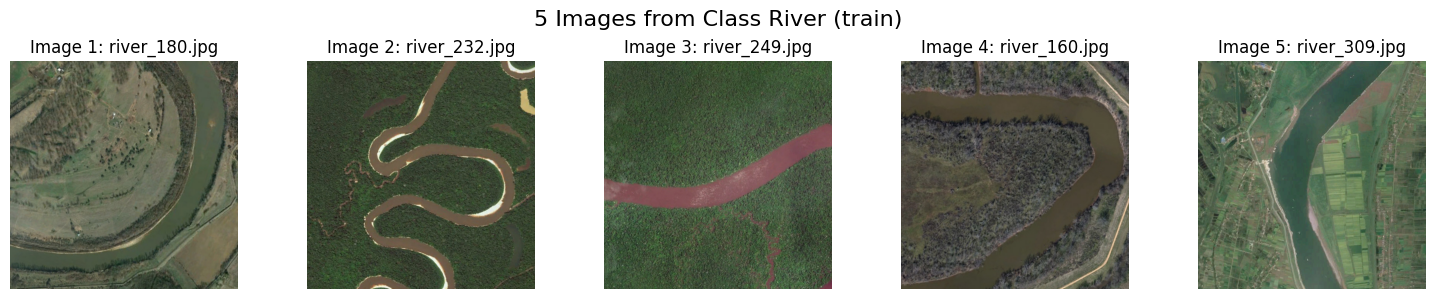

5 ảnh đã được lưu tại: /kaggle/working/River_train_5_images.png
Tổng số ảnh trong lớp River (train): 246


In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Đường dẫn đến thư mục đã chia
base_dir = '/kaggle/working/split_aid_dataset'
dataset_type = 'train'  # Có thể thay bằng 'val' hoặc 'test'
class_name = 'River'  # Thay bằng lớp bạn muốn (ví dụ: 'Beach', 'Forest', v.v.)

# Đường dẫn đến thư mục lớp
class_dir = os.path.join(base_dir, dataset_type, class_name)

# Kiểm tra xem thư mục tồn tại
if not os.path.exists(class_dir):
    print(f"Thư mục {class_dir} không tồn tại. Vui lòng chạy code chia dữ liệu trước.")
else:
    # Lấy danh sách ảnh trong thư mục lớp
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(image_files) < 5:
        print(f"Chỉ tìm thấy {len(image_files)} ảnh trong lớp {class_name}. Hiển thị tất cả.")
        selected_images = image_files
    else:
        selected_images = image_files[:5]  # Lấy 5 ảnh đầu tiên

    # Hiển thị 5 ảnh trong lưới 1x5
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    axes = axes.ravel()

    for idx, img_file in enumerate(selected_images):
        img_path = os.path.join(class_dir, img_file)
        try:
            img = Image.open(img_path).convert('RGB')
            axes[idx].imshow(img)
            axes[idx].set_title(f"Image {idx+1}: {img_file}")
            axes[idx].axis('off')
        except Exception as e:
            print(f"Lỗi khi load ảnh {img_file}: {e}")

    plt.suptitle(f"5 Images from Class {class_name} ({dataset_type})", fontsize=16)
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/{class_name}_{dataset_type}_5_images.png', dpi=300)
    plt.show()

    print(f"5 ảnh đã được lưu tại: /kaggle/working/{class_name}_{dataset_type}_5_images.png")
    print(f"Tổng số ảnh trong lớp {class_name} ({dataset_type}): {len(image_files)}")

In [7]:
# # Define the original transformations from your code
# train_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

# # Define additional augmentation transforms for demonstration
# augment_transforms = [
#     ("Horizontal Flip", transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.RandomHorizontalFlip(p=1.0),  # Force flip
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])),
#     ("Random Rotation", transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.RandomRotation(30),  # Rotate by up to 30 degrees
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])),
#     ("Color Jitter", transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])),
#     ("Random Crop", transforms.Compose([
#         transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ]))
# ]

# # Function to denormalize image for visualization
# def denormalize(tensor):
#     mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
#     std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
#     tensor = tensor * std + mean  # Reverse normalization
#     tensor = tensor.clamp(0, 1)  # Ensure pixel values are in [0, 1]
#     return tensor

# # Function to convert tensor to numpy for plotting
# def tensor_to_numpy(tensor):
#     tensor = denormalize(tensor)
#     return tensor.permute(1, 2, 0).numpy()

# # Load a sample image (replace with your dataset image path)
# # For demonstration, I'll create a dummy image or use a sample from the dataset
# try:
#     # Assuming we take the first image from the train_dataset
#     train_dataset = load_dataset(os.path.join('/kaggle/working/split_aid_dataset', 'train'), transforms.ToTensor())
#     sample_image, _ = train_dataset[0]  # Get the first image
#     original_image = sample_image
# except:
#     # If dataset is not accessible, create a dummy image
#     print("Could not load dataset. Using a dummy image for demonstration.")
#     original_image = Image.new('RGB', (224, 224), color='blue')  # Dummy image
#     original_image = transforms.ToTensor()(original_image)

# # Convert original image to PIL for augmentation
# original_pil = transforms.ToPILImage()(original_image)

# # Plotting the original and augmented images
# fig, axes = plt.subplots(1, len(augment_transforms) + 1, figsize=(15, 3))
# axes[0].imshow(tensor_to_numpy(original_image))
# axes[0].set_title("Original Image")
# axes[0].axis('off')

# # Apply and display each augmentation
# for i, (aug_name, aug_transform) in enumerate(augment_transforms):
#     augmented_image = aug_transform(original_pil)
#     axes[i + 1].imshow(tensor_to_numpy(augmented_image))
#     axes[i + 1].set_title(aug_name)
#     axes[i + 1].axis('off')

# plt.tight_layout()
# plt.show()

In [8]:
from torchvision import transforms as T, datasets
from torch.utils.data import DataLoader
# ========= 1. CÀI ĐẶT ĐƯỜNG DẪN VÀ TRANSFORM =========
base_dir = '/kaggle/working/split_aid_dataset'

# Chỉ giữ transform tối thiểu: Resize và ToTensor
train_transforms = T.Compose([
    T.Resize((224, 224)),  # Bắt buộc để khớp với input của Swin Transformer
    T.ToTensor(), 
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_dataset(root_dir, transform=None):
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"{root_dir} không tồn tại.")
    return datasets.ImageFolder(root=root_dir, transform=transform)

train_dataset = load_dataset(os.path.join(base_dir, 'train'), transform=train_transforms)
val_dataset = load_dataset(os.path.join(base_dir, 'val'), transform=val_test_transforms)
test_dataset = load_dataset(os.path.join(base_dir, 'test'), transform=val_test_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Kiểm tra giá trị inputs
for i, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {i} - Input min/max: {inputs.min().item():.4f}, {inputs.max().item():.4f}")
    if torch.isnan(inputs).any() or torch.isinf(inputs).any():
        print(f"[WARNING] NaN or Inf in inputs at batch {i}")
    if i >= 10:  # Chỉ kiểm tra 10 batch đầu tiên
        break

Batch 0 - Input min/max: -2.1179, 2.6400
Batch 1 - Input min/max: -2.1179, 2.6400
Batch 2 - Input min/max: -2.1179, 2.6400
Batch 3 - Input min/max: -2.1179, 2.6400
Batch 4 - Input min/max: -2.1179, 2.6400
Batch 5 - Input min/max: -2.1179, 2.6400
Batch 6 - Input min/max: -2.1179, 2.6400
Batch 7 - Input min/max: -2.1179, 2.6400
Batch 8 - Input min/max: -2.1179, 2.6400
Batch 9 - Input min/max: -2.1179, 2.6400
Batch 10 - Input min/max: -2.1179, 2.6400


In [9]:
import torch
import torch.nn as nn
from torchvision.models import swin_t, Swin_T_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = Swin_T_Weights.IMAGENET1K_V1
model = swin_t(weights=None)

# Lấy số lớp phân loại
num_classes = len(train_dataset.classes)
num_features = model.head.in_features

# Thay đổi phần head (thêm dropout)
model.head = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, num_classes)
)



In [10]:
model = model.to(device)
def print_model_summary(model):
    print("="*60)
    print(" Cấu trúc mô hình:")
    print(model)
    print("="*60)
    print("{:<60} {:>15} {:>15}".format("Tên lớp", "Số tham số", "Trainable"))
    print("-"*90)

    total_params = 0
    trainable_params = 0

    for name, param in model.named_parameters():
        num_params = param.numel()
        total_params += num_params
        if param.requires_grad:
            trainable_params += num_params
        print(f"{name:<60} {num_params:>15,} {str(param.requires_grad):>15}")

    print("-"*90)
    print(f"{'Tổng tham số':<60} {total_params:>15,}")
    print(f"{'Trainable parameters':<60} {trainable_params:>15,}")
    print(f"{'Non-trainable parameters':<60} {total_params - trainable_params:>15,}")
    print("="*60)

# 🔍 Gọi hàm sau khi model đã được định nghĩa và xử lý xong
print_model_summary(model)


 Cấu trúc mô hình:
SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransf

In [11]:
# Tham số hard-code
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_WORKERS = 4
EPOCHS = 100
ACCUMULATION_STEPS = 1
BASE_LR = 1e-4
MIN_LR = 1e-6
CLIP_GRAD = 5.0
WEIGHT_DECAY = 1e-4
LABEL_SMOOTHING = 0.1
OUTPUT_DIR = '/kaggle/working/output'
SAVE_FREQ = 1
PRINT_FREQ = 10
SEED = 42
AMP_ENABLE = True 

In [12]:
class NativeScalerWithGradNormCount:
    def __init__(self):
        self._scaler = torch.cuda.amp.GradScaler(enabled=True)

    def __call__(self, loss, optimizer, clip_grad=None, parameters=None, create_graph=False, update_grad=True):
        self._scaler.scale(loss).backward(create_graph=create_graph)
        if update_grad:
            if clip_grad is not None:
                self._scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(parameters, clip_grad)
            self._scaler.step(optimizer)
            self._scaler.update()
        return None  # Không tính grad norm

    def state_dict(self):
        return {"scale": self._scaler.get_scale()}

def build_optimizer(model):
    return torch.optim.AdamW(
        model.parameters(),
        lr=BASE_LR,
        weight_decay=WEIGHT_DECAY
    )

def build_scheduler(optimizer):
    return torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=EPOCHS,
        eta_min=MIN_LR
    )

In [13]:
def plot_training(history):
    if not history['train_loss']:
        print("Không có lịch sử huấn luyện để vẽ.")
        return

    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy"); plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['lr'], label='Learning Rate')
    plt.xlabel("Epoch"); plt.ylabel("LR"); plt.title("Learning Rate"); plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "training_plots.png"))
    plt.show()
    print(f"Đã lưu biểu đồ huấn luyện tại {os.path.join(OUTPUT_DIR, 'training_plots.png')}")

In [14]:
@torch.no_grad()
def evaluate(data_loader, model, criterion):
    model.eval()
    loss_meter = AverageMeter()
    acc1_meter = AverageMeter()

    total_images = 0
    start_time = time.time()

    for images, labels in data_loader:
        images, labels = images.cuda(non_blocking=True), labels.cuda(non_blocking=True)
        with torch.amp.autocast('cuda', enabled=AMP_ENABLE):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        acc1 = accuracy(outputs, labels, topk=(1,))[0]
        batch_size = images.size(0)
        loss_meter.update(loss.item(), batch_size)
        acc1_meter.update(acc1.item(), batch_size)
        total_images += batch_size

    inference_time = time.time() - start_time
    inference_speed = total_images / inference_time if inference_time > 0 else 0

    return loss_meter.avg, acc1_meter.avg, inference_speed

def train_one_epoch(model, criterion, data_loader, optimizer, epoch, lr_scheduler, loss_scaler):
    model.train()
    optimizer.zero_grad()

    num_steps = len(data_loader)
    batch_time = AverageMeter()
    loss_meter = AverageMeter()
    acc1_meter = AverageMeter()

    start = time.time()
    for idx, (images, targets) in enumerate(tqdm(data_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")):
        images, targets = images.cuda(non_blocking=True), targets.cuda(non_blocking=True)

        with torch.amp.autocast('cuda', enabled=AMP_ENABLE):
            outputs = model(images)
            loss = criterion(outputs, targets)
        
        loss = loss / ACCUMULATION_STEPS
        grad_norm = loss_scaler(loss, optimizer, clip_grad=CLIP_GRAD,
                                parameters=model.parameters(), update_grad=(idx + 1) % ACCUMULATION_STEPS == 0)
        if (idx + 1) % ACCUMULATION_STEPS == 0:
            optimizer.zero_grad()

        acc1 = accuracy(outputs, targets, topk=(1,))[0]
        batch_size = images.size(0)
        loss_meter.update(loss.item() * ACCUMULATION_STEPS, batch_size)
        acc1_meter.update(acc1.item(), batch_size)
        batch_time.update(time.time() - start)
        start = time.time()

        if idx % PRINT_FREQ == 0:
            lr = optimizer.param_groups[0]['lr']
    lr_scheduler.step()

    return loss_meter.avg, acc1_meter.avg

In [15]:
def load_model(model, model_path):
    """Load trạng thái mô hình từ file đã lưu."""
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"Đã tải mô hình từ {model_path}")
    else:
        print(f"Lỗi: File {model_path} không tồn tại.")
        raise FileNotFoundError(f"File {model_path} không tồn tại.")
    return model

def measure_inference_time(model, data_loader, device):
    """Đo thời gian suy luận trung bình trên mỗi mẫu."""
    model.to(device)
    model.eval()

    total_time = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device, non_blocking=True)
            # Đồng bộ CUDA để đo thời gian chính xác trên GPU
            if device.type == 'cuda':
                torch.cuda.synchronize()
            start_time = time.time()
            outputs = model(inputs)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            end_time = time.time()

            total_time += (end_time - start_time)
            total_samples += inputs.size(0)

    avg_time_ms = total_time / total_samples * 1000
    print(f"[{device}] Thời gian suy luận trung bình trên mỗi mẫu: {avg_time_ms:.4f} ms")
    return avg_time_ms

def evaluate_inference_time(model, data_loader, model_path):
    """Đo và lưu thời gian suy luận trên CPU và GPU."""
    # Load mô hình
    model = load_model(model, model_path)

    # Đo thời gian trên CPU
    print("\nĐo thời gian suy luận trên CPU...")
    cpu_time_ms = measure_inference_time(model, data_loader, torch.device('cpu'))

    # Đo thời gian trên GPU nếu có
    gpu_time_ms = None
    if torch.cuda.is_available():
        print("Đo thời gian suy luận trên GPU...")
        model = load_model(model, model_path)  # Load lại cho GPU
        gpu_time_ms = measure_inference_time(model, data_loader, torch.device('cuda'))

    # Lưu kết quả
    inference_times = {
        'cpu_time_ms': cpu_time_ms,
        'gpu_time_ms': gpu_time_ms
    }
    inference_times_path = os.path.join(OUTPUT_DIR, "inference_times.json")
    with open(inference_times_path, "w") as f:
        json.dump(inference_times, f)
    print(f"Đã lưu thời gian suy luận vào {inference_times_path}")

In [16]:
from datetime import timedelta
def main(model, train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader):
    # Di chuyển mô hình lên thiết bị
    model = model.cuda()

    # In cấu trúc mô hình
    print_model_summary(model)

    # Optimizer và scheduler
    optimizer = build_optimizer(model)
    lr_scheduler = build_scheduler(optimizer)
    loss_scaler = NativeScalerWithGradNormCount()

    # Loss functionZ
    criterion = LabelSmoothingCrossEntropy(smoothing=LABEL_SMOOTHING) if LABEL_SMOOTHING > 0 else nn.CrossEntropyLoss()

    # Lịch sử huấn luyện
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'lr': [], 'inference_speed': [], 'epoch_time': []
    }
    all_checkpoints = []
    best_loss = float('inf')  # Khởi tạo best_loss

    # Bắt đầu huấn luyện
    print("Bắt đầu huấn luyện")
    start_time = time.time()
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_one_epoch(model, criterion, train_loader, optimizer,
                                                epoch, lr_scheduler, loss_scaler)
        
        val_loss, val_acc, inference_speed = evaluate(val_loader, model, criterion)
        
        epoch_time = time.time() - start_time
        lr = optimizer.param_groups[0]['lr']
        
        print(
            f"\nEpoch {epoch+1}: "
            f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
            f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, "
            f"LR={lr:.6f}, Thời gian={epoch_time:.2f}s, "
            f"Inference time={inference_speed:.2f} ảnh/s"
        )

        # Lưu lịch sử
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['lr'].append(lr)
        history['inference_speed'].append(inference_speed)
        history['epoch_time'].append(epoch_time)
        start_time = time.time()  # Reset cho epoch tiếp theo

        # Lưu checkpoint
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_model_1.pth"))
            print("Đã lưu mô hình tốt nhất.")

        all_checkpoints.append({
            'epoch': epoch + 1,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': lr_scheduler.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'lr': lr,
            'inference_speed': inference_speed,
            'epoch_time': epoch_time
        })

    # Lưu kết quả
    torch.save(all_checkpoints, os.path.join(OUTPUT_DIR, "all_checkpoints_1.pth"))
    print("Đã lưu tất cả checkpoint vào all_checkpoints_1.pth")
    
    with open(os.path.join(OUTPUT_DIR, "training_log.json"), "w") as f:
        json.dump(history, f)
    print("Đã lưu nhật ký huấn luyện vào training_log.json")
    
    plot_training(history)

    # Đánh giá trên tập test
    if os.path.exists(os.path.join(OUTPUT_DIR, "best_model_1.pth")):
        model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, "best_model_1.pth")))
        test_loss, test_acc, _ = evaluate(test_loader, model, criterion)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    total_time = time.time() - start_time
    total_time_str = str(timedelta(seconds=int(total_time)))
    print(f'Thời gian huấn luyện tổng cộng: {total_time_str}')

/tmp/ipykernel_35/14740719.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler(enabled=True)


 Cấu trúc mô hình:
SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransf

Epoch 1/100: 100%|██████████| 188/188 [00:53<00:00,  3.52it/s]



Epoch 1: Train Loss=2.8819, Train Acc=21.2500, Val Loss=2.6617, Val Acc=26.5500, LR=0.000100, Thời gian=62.78s, Inference time=214.60 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 2/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 2: Train Loss=2.4890, Train Acc=31.8000, Val Loss=2.5036, Val Acc=33.0500, LR=0.000100, Thời gian=61.22s, Inference time=216.05 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 3/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 3: Train Loss=2.2188, Train Acc=41.9333, Val Loss=2.2880, Val Acc=43.2500, LR=0.000100, Thời gian=61.37s, Inference time=216.46 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 4/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 4: Train Loss=1.9773, Train Acc=51.6333, Val Loss=2.0153, Val Acc=50.7000, LR=0.000100, Thời gian=61.69s, Inference time=208.25 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 5/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 5: Train Loss=1.7628, Train Acc=59.3833, Val Loss=1.9048, Val Acc=55.6500, LR=0.000099, Thời gian=61.68s, Inference time=207.97 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 6/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 6: Train Loss=1.6251, Train Acc=64.9333, Val Loss=1.7848, Val Acc=60.7500, LR=0.000099, Thời gian=61.69s, Inference time=208.90 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 7/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 7: Train Loss=1.5048, Train Acc=69.2500, Val Loss=1.7926, Val Acc=58.8500, LR=0.000099, Thời gian=61.40s, Inference time=214.32 ảnh/s


Epoch 8/100: 100%|██████████| 188/188 [00:51<00:00,  3.62it/s]



Epoch 8: Train Loss=1.4083, Train Acc=74.2333, Val Loss=1.7570, Val Acc=61.0500, LR=0.000098, Thời gian=61.11s, Inference time=219.42 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 9/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 9: Train Loss=1.3147, Train Acc=77.2167, Val Loss=1.6428, Val Acc=65.7000, LR=0.000098, Thời gian=61.14s, Inference time=219.69 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 10/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 10: Train Loss=1.2312, Train Acc=80.2500, Val Loss=1.7039, Val Acc=65.1000, LR=0.000098, Thời gian=60.96s, Inference time=223.64 ảnh/s


Epoch 11/100: 100%|██████████| 188/188 [00:51<00:00,  3.64it/s]



Epoch 11: Train Loss=1.1551, Train Acc=83.4333, Val Loss=1.6442, Val Acc=65.4500, LR=0.000097, Thời gian=60.89s, Inference time=218.28 ảnh/s


Epoch 12/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 12: Train Loss=1.0801, Train Acc=86.5000, Val Loss=1.6661, Val Acc=65.4000, LR=0.000097, Thời gian=60.86s, Inference time=222.30 ảnh/s


Epoch 13/100: 100%|██████████| 188/188 [00:51<00:00,  3.62it/s]



Epoch 13: Train Loss=1.0389, Train Acc=88.2667, Val Loss=1.6587, Val Acc=66.4000, LR=0.000096, Thời gian=61.05s, Inference time=218.41 ảnh/s


Epoch 14/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 14: Train Loss=0.9798, Train Acc=91.2167, Val Loss=1.7384, Val Acc=64.4500, LR=0.000095, Thời gian=60.70s, Inference time=225.19 ảnh/s


Epoch 15/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 15: Train Loss=0.9240, Train Acc=93.3667, Val Loss=1.6249, Val Acc=68.9000, LR=0.000095, Thời gian=61.15s, Inference time=212.83 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 16/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 16: Train Loss=0.8964, Train Acc=94.4500, Val Loss=1.7081, Val Acc=64.6500, LR=0.000094, Thời gian=61.52s, Inference time=210.37 ảnh/s


Epoch 17/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 17: Train Loss=0.8675, Train Acc=95.7500, Val Loss=1.7324, Val Acc=64.3000, LR=0.000093, Thời gian=61.25s, Inference time=211.44 ảnh/s


Epoch 18/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 18: Train Loss=0.8383, Train Acc=96.6667, Val Loss=1.7265, Val Acc=64.9000, LR=0.000092, Thời gian=60.92s, Inference time=220.21 ảnh/s


Epoch 19/100: 100%|██████████| 188/188 [00:51<00:00,  3.62it/s]



Epoch 19: Train Loss=0.8208, Train Acc=97.2500, Val Loss=1.6287, Val Acc=68.0000, LR=0.000091, Thời gian=61.00s, Inference time=219.54 ảnh/s


Epoch 20/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 20: Train Loss=0.8104, Train Acc=97.3833, Val Loss=1.6024, Val Acc=67.5000, LR=0.000091, Thời gian=60.72s, Inference time=224.27 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 21/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 21: Train Loss=0.8081, Train Acc=97.4000, Val Loss=1.6568, Val Acc=66.8500, LR=0.000090, Thời gian=61.06s, Inference time=222.79 ảnh/s


Epoch 22/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 22: Train Loss=0.7878, Train Acc=98.2500, Val Loss=1.6329, Val Acc=67.4500, LR=0.000089, Thời gian=60.64s, Inference time=225.84 ảnh/s


Epoch 23/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 23: Train Loss=0.7822, Train Acc=97.9333, Val Loss=1.6311, Val Acc=67.5500, LR=0.000088, Thời gian=60.70s, Inference time=225.48 ảnh/s


Epoch 24/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 24: Train Loss=0.7700, Train Acc=98.5000, Val Loss=1.6165, Val Acc=68.7000, LR=0.000087, Thời gian=60.92s, Inference time=218.68 ảnh/s


Epoch 25/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 25: Train Loss=0.7623, Train Acc=98.6000, Val Loss=1.6092, Val Acc=69.2000, LR=0.000086, Thời gian=61.14s, Inference time=212.91 ảnh/s


Epoch 26/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 26: Train Loss=0.7492, Train Acc=99.0000, Val Loss=1.6248, Val Acc=68.7500, LR=0.000084, Thời gian=61.37s, Inference time=208.73 ảnh/s


Epoch 27/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 27: Train Loss=0.7578, Train Acc=98.5000, Val Loss=1.5920, Val Acc=68.9000, LR=0.000083, Thời gian=61.15s, Inference time=213.76 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 28/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 28: Train Loss=0.7472, Train Acc=98.8500, Val Loss=1.5948, Val Acc=69.4500, LR=0.000082, Thời gian=61.00s, Inference time=223.73 ảnh/s


Epoch 29/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 29: Train Loss=0.7374, Train Acc=99.0167, Val Loss=1.6037, Val Acc=68.5500, LR=0.000081, Thời gian=60.99s, Inference time=219.01 ảnh/s


Epoch 30/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 30: Train Loss=0.7374, Train Acc=98.9167, Val Loss=1.6209, Val Acc=69.3000, LR=0.000080, Thời gian=61.06s, Inference time=216.73 ảnh/s


Epoch 31/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 31: Train Loss=0.7450, Train Acc=98.8000, Val Loss=1.6096, Val Acc=67.8000, LR=0.000078, Thời gian=61.00s, Inference time=218.13 ảnh/s


Epoch 32/100: 100%|██████████| 188/188 [00:51<00:00,  3.62it/s]



Epoch 32: Train Loss=0.7244, Train Acc=99.3833, Val Loss=1.5545, Val Acc=70.4500, LR=0.000077, Thời gian=61.13s, Inference time=217.40 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 33/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 33: Train Loss=0.7321, Train Acc=99.0500, Val Loss=1.6206, Val Acc=67.0500, LR=0.000076, Thời gian=61.19s, Inference time=219.20 ảnh/s


Epoch 34/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 34: Train Loss=0.7191, Train Acc=99.4667, Val Loss=1.5952, Val Acc=68.6000, LR=0.000074, Thời gian=60.86s, Inference time=220.94 ảnh/s


Epoch 35/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 35: Train Loss=0.7199, Train Acc=99.1000, Val Loss=1.6360, Val Acc=67.8500, LR=0.000073, Thời gian=61.53s, Inference time=206.48 ảnh/s


Epoch 36/100: 100%|██████████| 188/188 [00:51<00:00,  3.62it/s]



Epoch 36: Train Loss=0.7236, Train Acc=98.9667, Val Loss=1.5884, Val Acc=68.8000, LR=0.000072, Thời gian=61.43s, Inference time=209.62 ảnh/s


Epoch 37/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 37: Train Loss=0.7210, Train Acc=99.0500, Val Loss=1.5855, Val Acc=69.3500, LR=0.000070, Thời gian=61.45s, Inference time=206.95 ảnh/s


Epoch 38/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 38: Train Loss=0.7085, Train Acc=99.4167, Val Loss=1.5836, Val Acc=68.9500, LR=0.000069, Thời gian=60.67s, Inference time=224.14 ảnh/s


Epoch 39/100: 100%|██████████| 188/188 [00:51<00:00,  3.62it/s]



Epoch 39: Train Loss=0.7052, Train Acc=99.5167, Val Loss=1.5672, Val Acc=69.5000, LR=0.000067, Thời gian=60.96s, Inference time=220.11 ảnh/s


Epoch 40/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 40: Train Loss=0.7028, Train Acc=99.3167, Val Loss=1.5595, Val Acc=69.8000, LR=0.000066, Thời gian=60.86s, Inference time=221.46 ảnh/s


Epoch 41/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 41: Train Loss=0.6964, Train Acc=99.5833, Val Loss=1.5465, Val Acc=70.1000, LR=0.000064, Thời gian=60.97s, Inference time=218.91 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 42/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 42: Train Loss=0.6960, Train Acc=99.5667, Val Loss=1.6427, Val Acc=67.2500, LR=0.000063, Thời gian=61.17s, Inference time=220.55 ảnh/s


Epoch 43/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 43: Train Loss=0.6951, Train Acc=99.6333, Val Loss=1.5838, Val Acc=69.0500, LR=0.000061, Thời gian=60.97s, Inference time=219.26 ảnh/s


Epoch 44/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 44: Train Loss=0.6958, Train Acc=99.5833, Val Loss=1.5636, Val Acc=69.5000, LR=0.000060, Thời gian=60.88s, Inference time=221.41 ảnh/s


Epoch 45/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 45: Train Loss=0.6903, Train Acc=99.6833, Val Loss=1.5647, Val Acc=69.7500, LR=0.000058, Thời gian=61.39s, Inference time=208.63 ảnh/s


Epoch 46/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 46: Train Loss=0.6937, Train Acc=99.5667, Val Loss=1.5448, Val Acc=70.7500, LR=0.000057, Thời gian=61.49s, Inference time=206.93 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 47/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 47: Train Loss=0.6895, Train Acc=99.5833, Val Loss=1.5297, Val Acc=70.2000, LR=0.000055, Thời gian=61.61s, Inference time=208.36 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 48/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 48: Train Loss=0.6861, Train Acc=99.7333, Val Loss=1.5280, Val Acc=70.7500, LR=0.000054, Thời gian=61.05s, Inference time=221.88 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 49/100: 100%|██████████| 188/188 [00:51<00:00,  3.62it/s]



Epoch 49: Train Loss=0.6832, Train Acc=99.7333, Val Loss=1.5640, Val Acc=69.7500, LR=0.000052, Thời gian=61.36s, Inference time=219.92 ảnh/s


Epoch 50/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 50: Train Loss=0.6857, Train Acc=99.7333, Val Loss=1.5430, Val Acc=70.8000, LR=0.000051, Thời gian=60.78s, Inference time=221.62 ảnh/s


Epoch 51/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 51: Train Loss=0.6849, Train Acc=99.5833, Val Loss=1.5354, Val Acc=70.2500, LR=0.000049, Thời gian=60.62s, Inference time=225.05 ảnh/s


Epoch 52/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 52: Train Loss=0.6865, Train Acc=99.4833, Val Loss=1.5526, Val Acc=69.7500, LR=0.000047, Thời gian=60.86s, Inference time=221.38 ảnh/s


Epoch 53/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 53: Train Loss=0.6820, Train Acc=99.8000, Val Loss=1.5373, Val Acc=69.4000, LR=0.000046, Thời gian=60.76s, Inference time=222.37 ảnh/s


Epoch 54/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 54: Train Loss=0.6782, Train Acc=99.6833, Val Loss=1.5564, Val Acc=69.6500, LR=0.000044, Thời gian=60.75s, Inference time=223.43 ảnh/s


Epoch 55/100: 100%|██████████| 188/188 [00:51<00:00,  3.64it/s]



Epoch 55: Train Loss=0.6774, Train Acc=99.7667, Val Loss=1.5469, Val Acc=71.1000, LR=0.000043, Thời gian=61.09s, Inference time=213.33 ảnh/s


Epoch 56/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 56: Train Loss=0.6770, Train Acc=99.7333, Val Loss=1.5283, Val Acc=70.8500, LR=0.000041, Thời gian=61.23s, Inference time=212.52 ảnh/s


Epoch 57/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 57: Train Loss=0.6755, Train Acc=99.7667, Val Loss=1.5492, Val Acc=69.9000, LR=0.000040, Thời gian=61.17s, Inference time=213.18 ảnh/s


Epoch 58/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 58: Train Loss=0.6723, Train Acc=99.7833, Val Loss=1.5280, Val Acc=69.9000, LR=0.000038, Thời gian=61.05s, Inference time=216.57 ảnh/s


Epoch 59/100: 100%|██████████| 188/188 [00:52<00:00,  3.61it/s]



Epoch 59: Train Loss=0.6710, Train Acc=99.8333, Val Loss=1.5476, Val Acc=70.2500, LR=0.000037, Thời gian=60.97s, Inference time=223.40 ảnh/s


Epoch 60/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 60: Train Loss=0.6683, Train Acc=99.9333, Val Loss=1.5619, Val Acc=69.0000, LR=0.000035, Thời gian=60.89s, Inference time=221.77 ảnh/s


Epoch 61/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 61: Train Loss=0.6716, Train Acc=99.7667, Val Loss=1.5216, Val Acc=70.5000, LR=0.000034, Thời gian=60.82s, Inference time=221.55 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 62/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 62: Train Loss=0.6703, Train Acc=99.8000, Val Loss=1.5203, Val Acc=70.7000, LR=0.000032, Thời gian=61.15s, Inference time=220.38 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 63/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 63: Train Loss=0.6705, Train Acc=99.8000, Val Loss=1.5423, Val Acc=70.3500, LR=0.000031, Thời gian=61.29s, Inference time=217.45 ảnh/s


Epoch 64/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 64: Train Loss=0.6678, Train Acc=99.8333, Val Loss=1.5460, Val Acc=70.3000, LR=0.000029, Thời gian=60.75s, Inference time=222.60 ảnh/s


Epoch 65/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 65: Train Loss=0.6661, Train Acc=99.9167, Val Loss=1.5581, Val Acc=71.2500, LR=0.000028, Thời gian=61.28s, Inference time=212.01 ảnh/s


Epoch 66/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 66: Train Loss=0.6661, Train Acc=99.8500, Val Loss=1.5457, Val Acc=70.1000, LR=0.000027, Thời gian=61.29s, Inference time=210.27 ảnh/s


Epoch 67/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 67: Train Loss=0.6669, Train Acc=99.8500, Val Loss=1.5511, Val Acc=70.2500, LR=0.000025, Thời gian=61.30s, Inference time=209.82 ảnh/s


Epoch 68/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 68: Train Loss=0.6672, Train Acc=99.8500, Val Loss=1.5415, Val Acc=70.3000, LR=0.000024, Thời gian=60.94s, Inference time=218.46 ảnh/s


Epoch 69/100: 100%|██████████| 188/188 [00:52<00:00,  3.62it/s]



Epoch 69: Train Loss=0.6649, Train Acc=99.9167, Val Loss=1.5220, Val Acc=70.6500, LR=0.000023, Thời gian=61.03s, Inference time=221.71 ảnh/s


Epoch 70/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 70: Train Loss=0.6628, Train Acc=99.9000, Val Loss=1.5308, Val Acc=70.9000, LR=0.000021, Thời gian=60.84s, Inference time=221.18 ảnh/s


Epoch 71/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 71: Train Loss=0.6638, Train Acc=99.8667, Val Loss=1.5174, Val Acc=71.2000, LR=0.000020, Thời gian=60.97s, Inference time=219.23 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 72/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 72: Train Loss=0.6624, Train Acc=99.9167, Val Loss=1.5293, Val Acc=70.6500, LR=0.000019, Thời gian=61.00s, Inference time=222.31 ảnh/s


Epoch 73/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 73: Train Loss=0.6620, Train Acc=99.9167, Val Loss=1.5410, Val Acc=70.3000, LR=0.000018, Thời gian=60.84s, Inference time=221.37 ảnh/s


Epoch 74/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 74: Train Loss=0.6616, Train Acc=99.9333, Val Loss=1.5409, Val Acc=70.5000, LR=0.000017, Thời gian=60.75s, Inference time=223.14 ảnh/s


Epoch 75/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 75: Train Loss=0.6614, Train Acc=99.8833, Val Loss=1.5231, Val Acc=70.6500, LR=0.000015, Thời gian=61.25s, Inference time=210.45 ảnh/s


Epoch 76/100: 100%|██████████| 188/188 [00:51<00:00,  3.64it/s]



Epoch 76: Train Loss=0.6607, Train Acc=99.9667, Val Loss=1.5390, Val Acc=70.3500, LR=0.000014, Thời gian=61.18s, Inference time=210.83 ảnh/s


Epoch 77/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 77: Train Loss=0.6622, Train Acc=99.8667, Val Loss=1.5277, Val Acc=70.4000, LR=0.000013, Thời gian=61.33s, Inference time=209.21 ảnh/s


Epoch 78/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 78: Train Loss=0.6606, Train Acc=99.9167, Val Loss=1.5295, Val Acc=70.5500, LR=0.000012, Thời gian=60.78s, Inference time=222.57 ảnh/s


Epoch 79/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 79: Train Loss=0.6614, Train Acc=99.8833, Val Loss=1.5241, Val Acc=70.4500, LR=0.000011, Thời gian=60.77s, Inference time=223.37 ảnh/s


Epoch 80/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 80: Train Loss=0.6592, Train Acc=99.9500, Val Loss=1.5078, Val Acc=71.0000, LR=0.000010, Thời gian=60.81s, Inference time=222.00 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 81/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 81: Train Loss=0.6598, Train Acc=99.9500, Val Loss=1.4948, Val Acc=71.2500, LR=0.000010, Thời gian=61.59s, Inference time=209.55 ảnh/s
Đã lưu mô hình tốt nhất.


Epoch 82/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 82: Train Loss=0.6579, Train Acc=99.9833, Val Loss=1.4993, Val Acc=71.5500, LR=0.000009, Thời gian=61.19s, Inference time=217.97 ảnh/s


Epoch 83/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 83: Train Loss=0.6585, Train Acc=99.9500, Val Loss=1.5030, Val Acc=71.2500, LR=0.000008, Thời gian=60.82s, Inference time=220.97 ảnh/s


Epoch 84/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 84: Train Loss=0.6603, Train Acc=99.8500, Val Loss=1.5015, Val Acc=70.9500, LR=0.000007, Thời gian=60.73s, Inference time=223.15 ảnh/s


Epoch 85/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 85: Train Loss=0.6586, Train Acc=99.9667, Val Loss=1.5041, Val Acc=71.0500, LR=0.000006, Thời gian=61.48s, Inference time=206.13 ảnh/s


Epoch 86/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 86: Train Loss=0.6575, Train Acc=100.0000, Val Loss=1.5181, Val Acc=71.0000, LR=0.000006, Thời gian=61.21s, Inference time=212.36 ảnh/s


Epoch 87/100: 100%|██████████| 188/188 [00:51<00:00,  3.64it/s]



Epoch 87: Train Loss=0.6570, Train Acc=99.9667, Val Loss=1.5072, Val Acc=71.2000, LR=0.000005, Thời gian=61.30s, Inference time=208.74 ảnh/s


Epoch 88/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 88: Train Loss=0.6565, Train Acc=99.9667, Val Loss=1.5133, Val Acc=71.0000, LR=0.000004, Thời gian=60.65s, Inference time=224.92 ảnh/s


Epoch 89/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 89: Train Loss=0.6575, Train Acc=99.9333, Val Loss=1.5114, Val Acc=71.1000, LR=0.000004, Thời gian=60.90s, Inference time=221.33 ảnh/s


Epoch 90/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 90: Train Loss=0.6568, Train Acc=99.9500, Val Loss=1.5070, Val Acc=71.6000, LR=0.000003, Thời gian=60.91s, Inference time=219.30 ảnh/s


Epoch 91/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 91: Train Loss=0.6568, Train Acc=99.9667, Val Loss=1.5049, Val Acc=71.2000, LR=0.000003, Thời gian=61.03s, Inference time=216.23 ảnh/s


Epoch 92/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 92: Train Loss=0.6570, Train Acc=99.9833, Val Loss=1.5073, Val Acc=71.5000, LR=0.000003, Thời gian=60.92s, Inference time=219.06 ảnh/s


Epoch 93/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 93: Train Loss=0.6569, Train Acc=99.9500, Val Loss=1.5056, Val Acc=71.4000, LR=0.000002, Thời gian=60.86s, Inference time=220.68 ảnh/s


Epoch 94/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 94: Train Loss=0.6569, Train Acc=99.9667, Val Loss=1.5044, Val Acc=71.2000, LR=0.000002, Thời gian=60.80s, Inference time=221.39 ảnh/s


Epoch 95/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 95: Train Loss=0.6580, Train Acc=99.9333, Val Loss=1.5088, Val Acc=70.9500, LR=0.000002, Thời gian=61.33s, Inference time=210.29 ảnh/s


Epoch 96/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 96: Train Loss=0.6564, Train Acc=99.9667, Val Loss=1.5102, Val Acc=70.9500, LR=0.000001, Thời gian=61.58s, Inference time=204.46 ảnh/s


Epoch 97/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 97: Train Loss=0.6561, Train Acc=99.9500, Val Loss=1.5039, Val Acc=71.0500, LR=0.000001, Thời gian=61.43s, Inference time=206.62 ảnh/s


Epoch 98/100: 100%|██████████| 188/188 [00:51<00:00,  3.62it/s]



Epoch 98: Train Loss=0.6550, Train Acc=100.0000, Val Loss=1.5064, Val Acc=71.1000, LR=0.000001, Thời gian=60.92s, Inference time=222.38 ảnh/s


Epoch 99/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 99: Train Loss=0.6563, Train Acc=99.9833, Val Loss=1.5031, Val Acc=71.3500, LR=0.000001, Thời gian=60.97s, Inference time=219.43 ảnh/s


Epoch 100/100: 100%|██████████| 188/188 [00:51<00:00,  3.63it/s]



Epoch 100: Train Loss=0.6568, Train Acc=99.9833, Val Loss=1.5019, Val Acc=71.1000, LR=0.000001, Thời gian=60.78s, Inference time=224.18 ảnh/s
Đã lưu tất cả checkpoint vào all_checkpoints_1.pth
Đã lưu nhật ký huấn luyện vào training_log.json


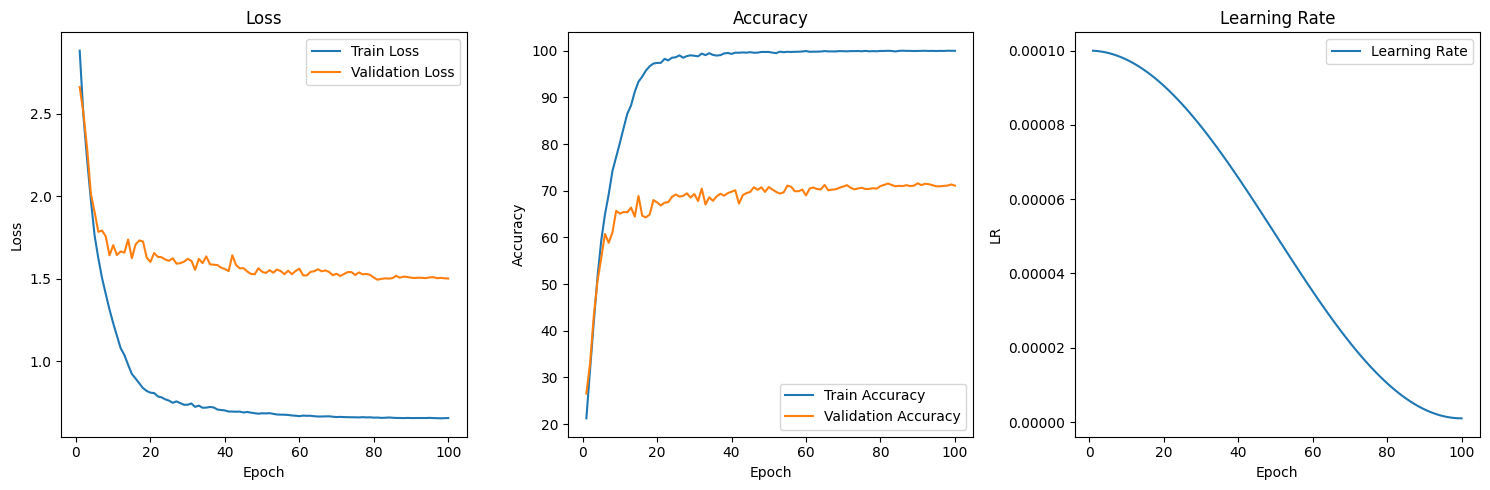

Đã lưu biểu đồ huấn luyện tại /kaggle/working/output/training_plots.png
Test Loss: 1.4504, Test Accuracy: 72.9000
Thời gian huấn luyện tổng cộng: 0:00:11


In [17]:
if __name__ == '__main__':
    # Cài đặt thư viện cần thiết trên Kaggle
    try:
        import timm
    except ImportError:
        !pip install timm
        import timm

    # Cài đặt seed
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    cudnn.benchmark = True

    # Tạo output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Chạy huấn luyện
    main(model, train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader)

In [18]:
# Load mô hình và đo thời gian suy luận/đánh giá
model_path = os.path.join(OUTPUT_DIR, "best_model_1.pth")
model = load_model(model, model_path)

device_cpu = torch.device('cpu')
device_gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Đo thời gian suy luận
cpu_time_ms = None
gpu_time_ms = None

print("Measuring on CPU...")
cpu_time_ms = measure_inference_time(model, test_loader, device_cpu)

if torch.cuda.is_available():
    print("Measuring on GPU...")
    gpu_time_ms = measure_inference_time(model, test_loader, device_gpu)

# Lưu thời gian suy luận
inference_times = {
    'cpu_time_ms': cpu_time_ms,
    'gpu_time_ms': gpu_time_ms
}
inference_times_path = os.path.join(OUTPUT_DIR, "inference_times.json")
with open(inference_times_path, "w") as f:
    json.dump(inference_times, f)
print(f"Đã lưu thời gian suy luận vào {inference_times_path}")

Đã tải mô hình từ /kaggle/working/output/best_model_1.pth
Measuring on CPU...
[cpu] Thời gian suy luận trung bình trên mỗi mẫu: 107.8964 ms
Measuring on GPU...
[cuda] Thời gian suy luận trung bình trên mỗi mẫu: 2.5687 ms
Đã lưu thời gian suy luận vào /kaggle/working/output/inference_times.json
